In [1]:
import modules.era5 as era5

%matplotlib inline

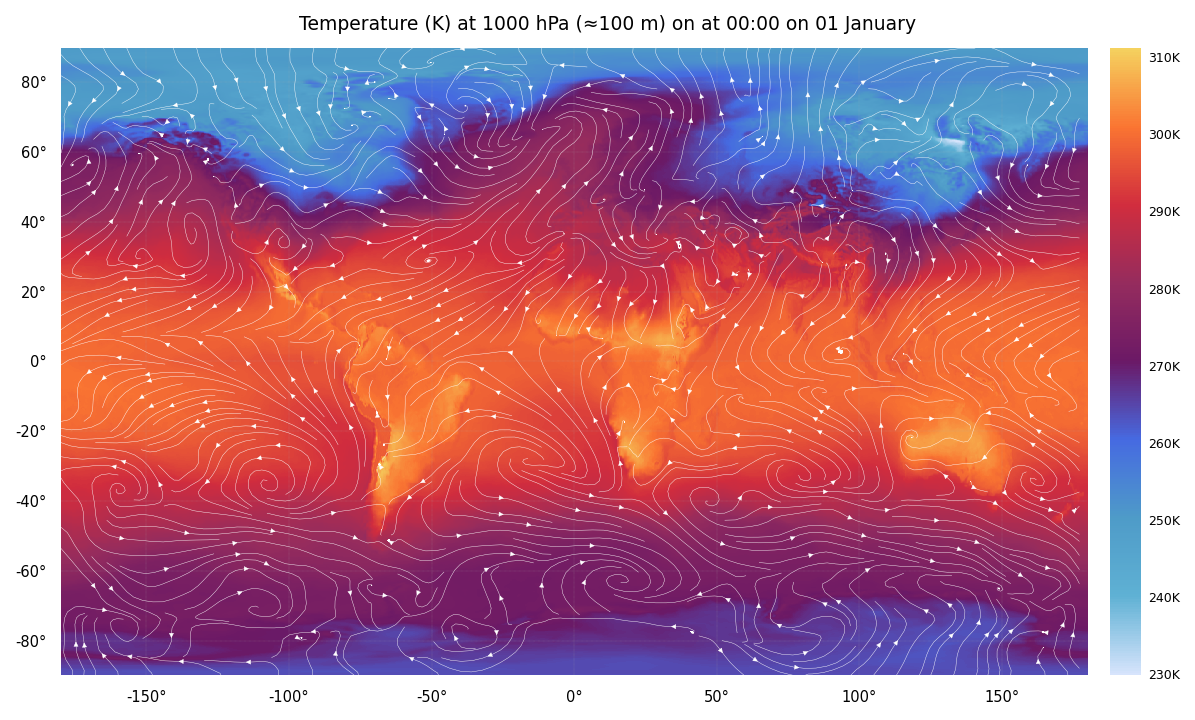

In [2]:
temperature = era5.Temperature()
u = era5.UWind()
v = era5.VWind()
w = era5.VerticalVelocity()

plot = era5.ImagePlot2D(temperature, ["TAVG-01-01 00:00", 1000])
plot.plot()
plot.add_streamlines(u, v)

plot.show()

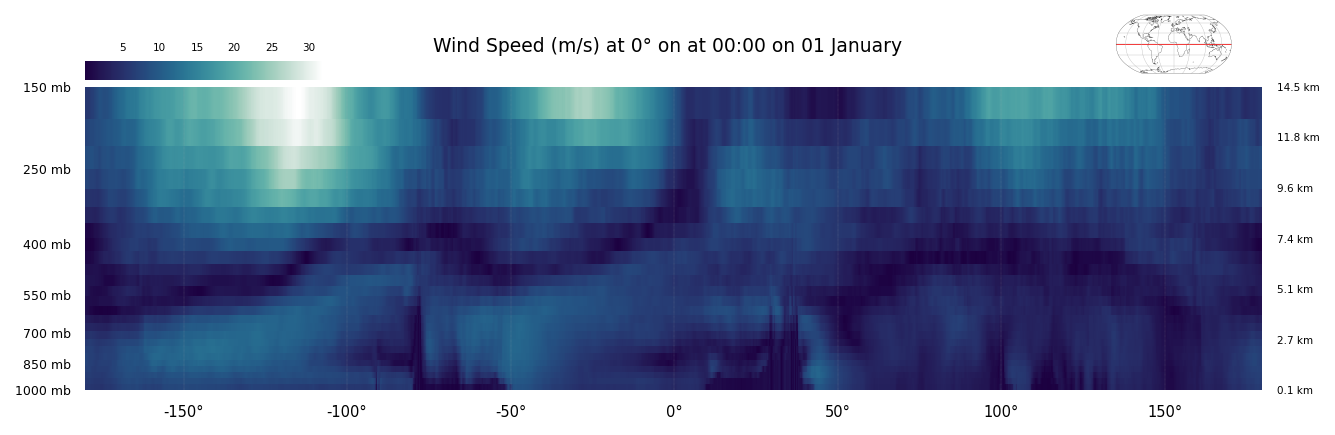

In [3]:
speed = era5.WindSpeed()

plot = era5.ImagePlot2D(speed, ["TAVG-01-01 00:00", None, 0])
plot.plot()
plot.show()

/Users/bhavyemathur/DataspellProjects/wind-prediction-merra2/modules/era5/plotting/plot.py:378: UserWarning: The following kwargs were not used by contour: 'aspect'
  return self._ax.contourf(*self._get_mesh(), self._data, **kwargs)


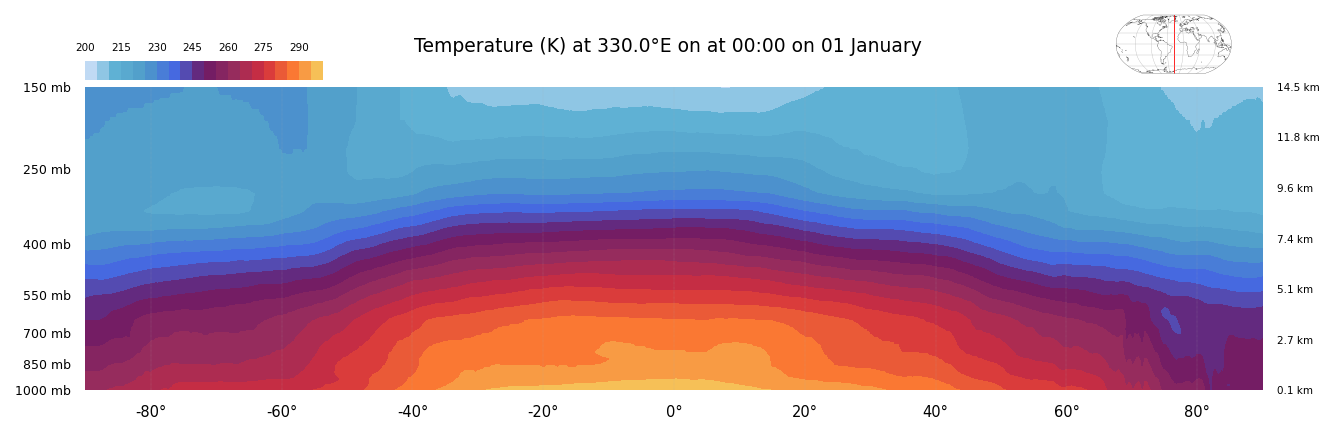

In [4]:
plot = era5.Contourf2D(temperature, ["TAVG-01-01 00:00", None, None, -30])
plot.plot()
plot.show()

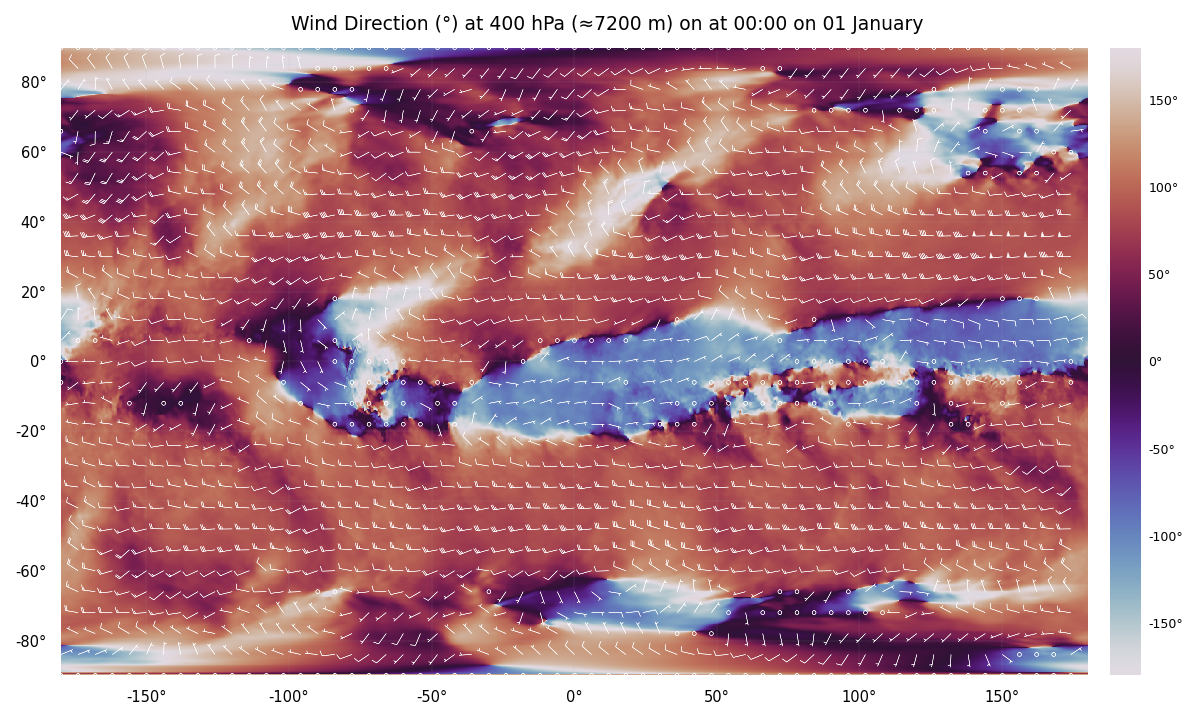

In [5]:
direction = era5.WindDirection()

plot = era5.ImagePlot2D(direction, ["TAVG-01-01 00:00", 400])
plot.plot()
plot.add_barbs(u, v)

plot.show()

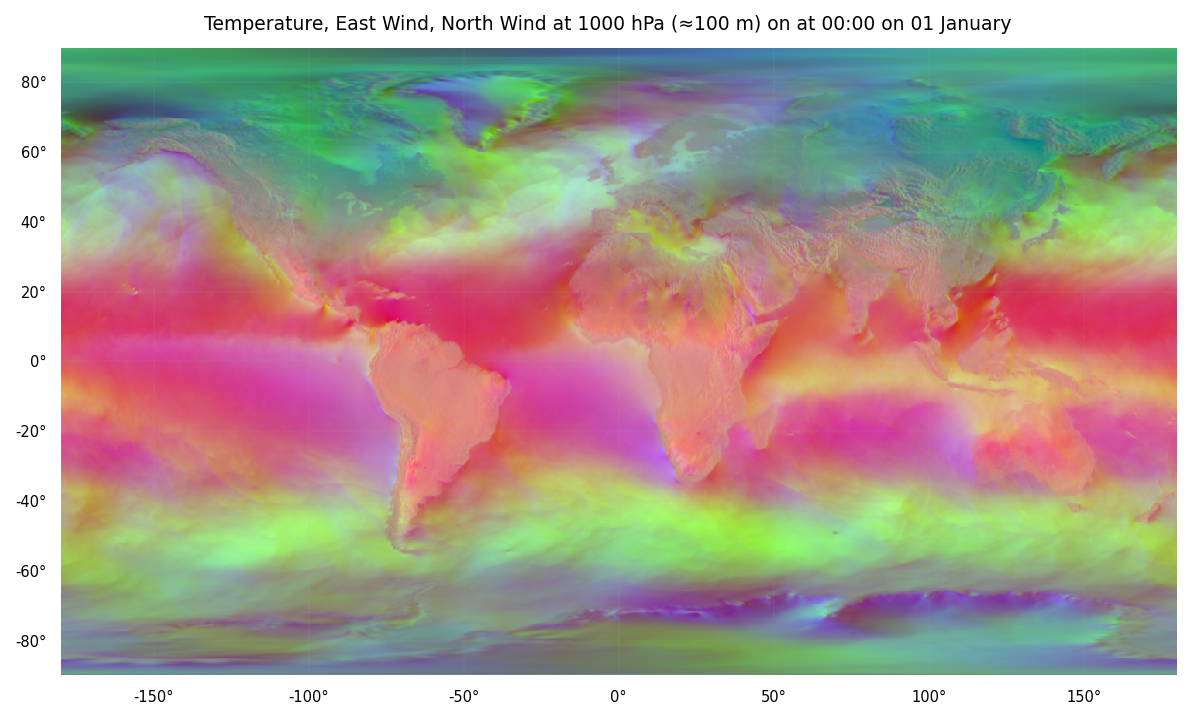

In [7]:
plot = era5.ImagePlot2D((temperature, u, v), ["TAVG-01-01 00:00", 1000])
plot.plot()
plot.show()

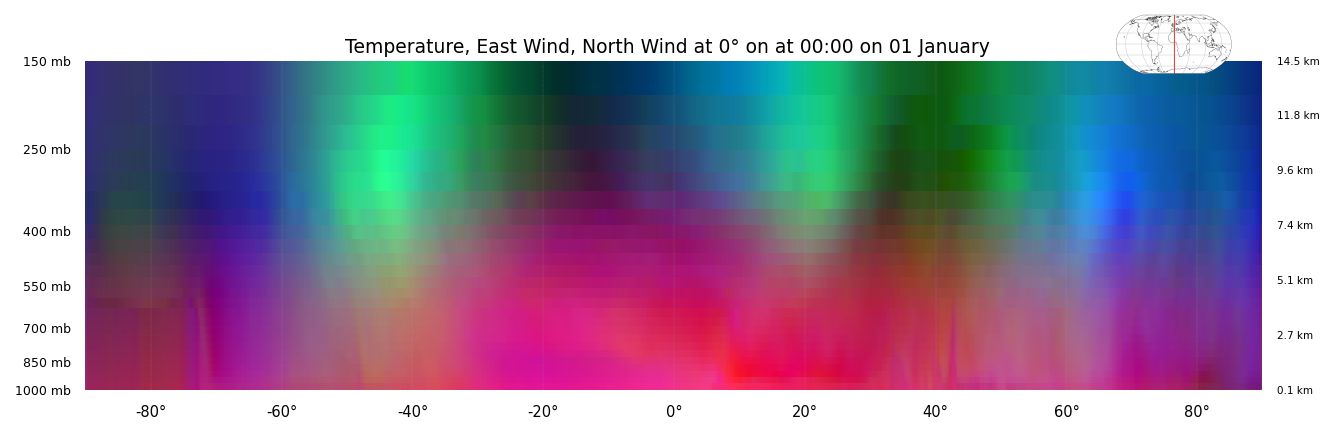

In [13]:
plot = era5.ImagePlot2D((temperature, u, v), ["TAVG-01-01 00:00", None, None, 0])
plot.plot()
plot.show()